In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')


Searchlight analysis of face vs house recognition
==================================================

Searchlight analysis requires fitting a classifier a large amount of
times. As a result, it is an intrinsically slow method. In order to speed
up computing, in this example, Searchlight is run on a few slices of
the fMRI dataset for a single subject.

Load Haxby dataset
-------------------



In [3]:
import pandas as pd
import numpy as np
from nilearn import datasets
from nilearn.image import new_img_like, load_img, index_img

haxby_dataset = datasets.fetch_haxby()

# print basic information on the first subject in the dataset:
print('Anatomical nifti image (3D) is located at: %s' % haxby_dataset.anat[0])
print('Functional nifti image (4D) is located at: %s' % haxby_dataset.func[0])

fmri_filename = haxby_dataset.func[0]
labels = pd.read_csv(haxby_dataset.session_target[0], sep=" ")

y = labels['labels']
session = labels['chunks'] #individual runs

Anatomical nifti image (3D) is located at: /Users/suesong/nilearn_data/haxby2001/subj2/anat.nii.gz
Functional nifti image (4D) is located at: /Users/suesong/nilearn_data/haxby2001/subj2/bold.nii.gz


Restrict to faces and houses
------------------------------



In [4]:
condition_mask = y.isin(['face', 'house'])

fmri_img = index_img(fmri_filename, condition_mask)
y, session = y[condition_mask], session[condition_mask]

Prepare masks
--------------
- mask_img is the original mask
- process_mask_img is a subset of mask_img, it contains the voxels that
  should be processed (we only keep slices 26-28 and the back of the
  brain to speed up computation)

In [5]:
mask_img = load_img(haxby_dataset.mask)

# .astype() makes a copy.
process_mask = mask_img.get_data().astype(np.int)
picked_slice = 26
process_mask[..., (picked_slice + 3):] = 0
#process_mask[..., :picked_slice] = 0
process_mask[..., 30:] = 0
process_mask_img = new_img_like(mask_img, process_mask)

In [6]:
session.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

Searchlight computation
-------------------------



In [7]:
# Make processing parallel
# /!\ As each thread will print its progress, n_jobs > 1 will make the
#     information output a bit difficult to read.
n_jobs = -1

# Define the cross-validation scheme used for validation.
# Here we use a LeaveOneGroupOut cross-validation, leaving each fmri session out, which corresponds to
# splitting the samples in 12 folds and make  runs using each fold as a test
from sklearn.model_selection import LeaveOneGroupOut
cv = LeaveOneGroupOut()

from nilearn.decoding import SearchLight
# The radius dictates the size of the Searchlight sphere that will scan the volume
# By default, the searchlight uses a linear support vector machine, however, we can provide any 
# classifier we want into the clf parameter, which is currently implicit
searchlight = SearchLight(
    mask_img,
    process_mask_img=process_mask_img,
    radius=6,
    scoring="accuracy",
    n_jobs=n_jobs,
    verbose=1,
    cv=cv)
searchlight.fit(fmri_img, y, groups=session) #groups goes into the call to fit, not into searchlight directly

Job #1, processed 0/3328 voxels (0.00%, 1633 seconds remaining)
Job #2, processed 0/3327 voxels (0.00%, 3173 seconds remaining)
Job #3, processed 0/3327 voxels (0.00%, 3457 seconds remaining)
Job #4, processed 0/3327 voxels (0.00%, 3599 seconds remaining)
Job #1, processed 10/3328 voxels (0.30%, 813 seconds remaining)
Job #2, processed 10/3327 voxels (0.30%, 1190 seconds remaining)
Job #3, processed 10/3327 voxels (0.30%, 1207 seconds remaining)
Job #4, processed 10/3327 voxels (0.30%, 1297 seconds remaining)
Job #1, processed 20/3328 voxels (0.60%, 782 seconds remaining)
Job #3, processed 20/3327 voxels (0.60%, 1051 seconds remaining)
Job #2, processed 20/3327 voxels (0.60%, 1104 seconds remaining)
Job #1, processed 30/3328 voxels (0.90%, 746 seconds remaining)
Job #4, processed 20/3327 voxels (0.60%, 1168 seconds remaining)
Job #1, processed 40/3328 voxels (1.20%, 764 seconds remaining)
Job #3, processed 30/3327 voxels (0.90%, 1045 seconds remaining)
Job #2, processed 30/3327 voxels 

Job #4, processed 300/3327 voxels (9.02%, 1010 seconds remaining)
Job #2, processed 310/3327 voxels (9.32%, 993 seconds remaining)
Job #1, processed 340/3328 voxels (10.22%, 900 seconds remaining)
Job #4, processed 310/3327 voxels (9.32%, 1000 seconds remaining)
Job #3, processed 310/3327 voxels (9.32%, 1002 seconds remaining)
Job #1, processed 350/3328 voxels (10.52%, 891 seconds remaining)
Job #2, processed 320/3327 voxels (9.62%, 986 seconds remaining)
Job #4, processed 320/3327 voxels (9.62%, 992 seconds remaining)
Job #3, processed 320/3327 voxels (9.62%, 994 seconds remaining)
Job #1, processed 360/3328 voxels (10.82%, 884 seconds remaining)
Job #2, processed 330/3327 voxels (9.92%, 979 seconds remaining)
Job #4, processed 330/3327 voxels (9.92%, 980 seconds remaining)
Job #3, processed 330/3327 voxels (9.92%, 987 seconds remaining)
Job #1, processed 370/3328 voxels (11.12%, 880 seconds remaining)
Job #4, processed 340/3327 voxels (10.22%, 971 seconds remaining)
Job #2, processed

Job #4, processed 610/3327 voxels (18.33%, 854 seconds remaining)
Job #1, processed 660/3328 voxels (19.83%, 780 seconds remaining)
Job #2, processed 620/3327 voxels (18.64%, 843 seconds remaining)
Job #3, processed 620/3327 voxels (18.64%, 844 seconds remaining)
Job #4, processed 620/3327 voxels (18.64%, 849 seconds remaining)
Job #1, processed 670/3328 voxels (20.13%, 777 seconds remaining)
Job #2, processed 630/3327 voxels (18.94%, 839 seconds remaining)
Job #3, processed 630/3327 voxels (18.94%, 840 seconds remaining)
Job #4, processed 630/3327 voxels (18.94%, 844 seconds remaining)
Job #1, processed 680/3328 voxels (20.43%, 773 seconds remaining)
Job #2, processed 640/3327 voxels (19.24%, 835 seconds remaining)
Job #3, processed 640/3327 voxels (19.24%, 836 seconds remaining)
Job #4, processed 640/3327 voxels (19.24%, 840 seconds remaining)
Job #1, processed 690/3328 voxels (20.73%, 769 seconds remaining)
Job #2, processed 650/3327 voxels (19.54%, 830 seconds remaining)
Job #3, pr

Job #4, processed 920/3327 voxels (27.65%, 721 seconds remaining)
Job #2, processed 930/3327 voxels (27.95%, 715 seconds remaining)
Job #1, processed 980/3328 voxels (29.45%, 665 seconds remaining)
Job #3, processed 930/3327 voxels (27.95%, 716 seconds remaining)
Job #4, processed 930/3327 voxels (27.95%, 717 seconds remaining)
Job #2, processed 940/3327 voxels (28.25%, 711 seconds remaining)
Job #1, processed 990/3328 voxels (29.75%, 662 seconds remaining)
Job #3, processed 940/3327 voxels (28.25%, 712 seconds remaining)
Job #4, processed 940/3327 voxels (28.25%, 714 seconds remaining)
Job #2, processed 950/3327 voxels (28.55%, 706 seconds remaining)
Job #1, processed 1000/3328 voxels (30.05%, 659 seconds remaining)
Job #3, processed 950/3327 voxels (28.55%, 709 seconds remaining)
Job #4, processed 950/3327 voxels (28.55%, 710 seconds remaining)
Job #2, processed 960/3327 voxels (28.85%, 702 seconds remaining)
Job #1, processed 1010/3328 voxels (30.35%, 656 seconds remaining)
Job #3, 

Job #2, processed 1230/3327 voxels (36.97%, 612 seconds remaining)
Job #3, processed 1230/3327 voxels (36.97%, 613 seconds remaining)
Job #1, processed 1290/3328 voxels (38.76%, 570 seconds remaining)
Job #4, processed 1240/3327 voxels (37.27%, 607 seconds remaining)
Job #2, processed 1240/3327 voxels (37.27%, 609 seconds remaining)
Job #3, processed 1240/3327 voxels (37.27%, 610 seconds remaining)
Job #1, processed 1300/3328 voxels (39.06%, 567 seconds remaining)
Job #4, processed 1250/3327 voxels (37.57%, 604 seconds remaining)
Job #2, processed 1250/3327 voxels (37.57%, 605 seconds remaining)
Job #3, processed 1250/3327 voxels (37.57%, 607 seconds remaining)
Job #1, processed 1310/3328 voxels (39.36%, 564 seconds remaining)
Job #4, processed 1260/3327 voxels (37.87%, 601 seconds remaining)
Job #2, processed 1260/3327 voxels (37.87%, 602 seconds remaining)
Job #3, processed 1260/3327 voxels (37.87%, 604 seconds remaining)
Job #1, processed 1320/3328 voxels (39.66%, 562 seconds remain

Job #4, processed 1540/3327 voxels (46.29%, 516 seconds remaining)
Job #2, processed 1540/3327 voxels (46.29%, 516 seconds remaining)
Job #3, processed 1540/3327 voxels (46.29%, 517 seconds remaining)
Job #4, processed 1550/3327 voxels (46.59%, 513 seconds remaining)
Job #1, processed 1600/3328 voxels (48.08%, 483 seconds remaining)
Job #2, processed 1550/3327 voxels (46.59%, 513 seconds remaining)
Job #3, processed 1550/3327 voxels (46.59%, 514 seconds remaining)
Job #4, processed 1560/3327 voxels (46.89%, 509 seconds remaining)
Job #1, processed 1610/3328 voxels (48.38%, 480 seconds remaining)
Job #2, processed 1560/3327 voxels (46.89%, 510 seconds remaining)
Job #3, processed 1560/3327 voxels (46.89%, 511 seconds remaining)
Job #4, processed 1570/3327 voxels (47.19%, 506 seconds remaining)
Job #1, processed 1620/3328 voxels (48.68%, 477 seconds remaining)
Job #2, processed 1570/3327 voxels (47.19%, 507 seconds remaining)
Job #3, processed 1570/3327 voxels (47.19%, 508 seconds remain

Job #4, processed 1850/3327 voxels (55.61%, 421 seconds remaining)
Job #1, processed 1900/3328 voxels (57.09%, 397 seconds remaining)
Job #2, processed 1850/3327 voxels (55.61%, 421 seconds remaining)
Job #3, processed 1850/3327 voxels (55.61%, 423 seconds remaining)
Job #4, processed 1860/3327 voxels (55.91%, 418 seconds remaining)
Job #1, processed 1910/3328 voxels (57.39%, 394 seconds remaining)
Job #2, processed 1860/3327 voxels (55.91%, 418 seconds remaining)
Job #4, processed 1870/3327 voxels (56.21%, 414 seconds remaining)
Job #3, processed 1860/3327 voxels (55.91%, 419 seconds remaining)
Job #2, processed 1870/3327 voxels (56.21%, 415 seconds remaining)
Job #1, processed 1920/3328 voxels (57.69%, 391 seconds remaining)
Job #4, processed 1880/3327 voxels (56.51%, 411 seconds remaining)
Job #3, processed 1870/3327 voxels (56.21%, 416 seconds remaining)
Job #2, processed 1880/3327 voxels (56.51%, 412 seconds remaining)
Job #1, processed 1930/3328 voxels (57.99%, 388 seconds remain

Job #2, processed 2150/3327 voxels (64.62%, 333 seconds remaining)
Job #3, processed 2150/3327 voxels (64.62%, 334 seconds remaining)
Job #1, processed 2210/3328 voxels (66.41%, 308 seconds remaining)
Job #4, processed 2170/3327 voxels (65.22%, 326 seconds remaining)
Job #2, processed 2160/3327 voxels (64.92%, 330 seconds remaining)
Job #3, processed 2160/3327 voxels (64.92%, 331 seconds remaining)
Job #1, processed 2220/3328 voxels (66.71%, 306 seconds remaining)
Job #4, processed 2180/3327 voxels (65.52%, 323 seconds remaining)
Job #2, processed 2170/3327 voxels (65.22%, 327 seconds remaining)
Job #3, processed 2170/3327 voxels (65.22%, 328 seconds remaining)
Job #1, processed 2230/3328 voxels (67.01%, 303 seconds remaining)
Job #4, processed 2190/3327 voxels (65.83%, 320 seconds remaining)
Job #2, processed 2180/3327 voxels (65.52%, 324 seconds remaining)
Job #3, processed 2180/3327 voxels (65.52%, 325 seconds remaining)
Job #1, processed 2240/3328 voxels (67.31%, 300 seconds remain

Job #4, processed 2480/3327 voxels (74.54%, 236 seconds remaining)
Job #2, processed 2460/3327 voxels (73.94%, 243 seconds remaining)
Job #1, processed 2510/3328 voxels (75.42%, 225 seconds remaining)
Job #3, processed 2460/3327 voxels (73.94%, 244 seconds remaining)
Job #4, processed 2490/3327 voxels (74.84%, 233 seconds remaining)
Job #2, processed 2470/3327 voxels (74.24%, 240 seconds remaining)
Job #1, processed 2520/3328 voxels (75.72%, 222 seconds remaining)
Job #3, processed 2470/3327 voxels (74.24%, 241 seconds remaining)
Job #1, processed 2530/3328 voxels (76.02%, 219 seconds remaining)
Job #4, processed 2500/3327 voxels (75.14%, 230 seconds remaining)
Job #2, processed 2480/3327 voxels (74.54%, 238 seconds remaining)
Job #3, processed 2480/3327 voxels (74.54%, 238 seconds remaining)
Job #4, processed 2510/3327 voxels (75.44%, 227 seconds remaining)
Job #1, processed 2540/3328 voxels (76.32%, 216 seconds remaining)
Job #2, processed 2490/3327 voxels (74.84%, 235 seconds remain

Job #1, processed 2810/3328 voxels (84.44%, 142 seconds remaining)
Job #2, processed 2760/3327 voxels (82.96%, 158 seconds remaining)
Job #3, processed 2760/3327 voxels (82.96%, 158 seconds remaining)
Job #4, processed 2810/3327 voxels (84.46%, 142 seconds remaining)
Job #1, processed 2820/3328 voxels (84.74%, 139 seconds remaining)
Job #3, processed 2770/3327 voxels (83.26%, 156 seconds remaining)
Job #2, processed 2770/3327 voxels (83.26%, 156 seconds remaining)
Job #4, processed 2820/3327 voxels (84.76%, 139 seconds remaining)
Job #1, processed 2830/3328 voxels (85.04%, 136 seconds remaining)
Job #3, processed 2780/3327 voxels (83.56%, 153 seconds remaining)
Job #2, processed 2780/3327 voxels (83.56%, 153 seconds remaining)
Job #4, processed 2830/3327 voxels (85.06%, 136 seconds remaining)
Job #1, processed 2840/3328 voxels (85.34%, 134 seconds remaining)
Job #3, processed 2790/3327 voxels (83.86%, 150 seconds remaining)
Job #2, processed 2790/3327 voxels (83.86%, 150 seconds remain

Job #3, processed 3060/3327 voxels (91.97%, 74 seconds remaining)
Job #4, processed 3130/3327 voxels (94.08%, 53 seconds remaining)
Job #1, processed 3120/3328 voxels (93.75%, 57 seconds remaining)
Job #2, processed 3070/3327 voxels (92.28%, 71 seconds remaining)
Job #3, processed 3070/3327 voxels (92.28%, 71 seconds remaining)
Job #4, processed 3140/3327 voxels (94.38%, 51 seconds remaining)
Job #1, processed 3130/3328 voxels (94.05%, 54 seconds remaining)
Job #2, processed 3080/3327 voxels (92.58%, 68 seconds remaining)
Job #3, processed 3080/3327 voxels (92.58%, 68 seconds remaining)
Job #4, processed 3150/3327 voxels (94.68%, 48 seconds remaining)
Job #1, processed 3140/3328 voxels (94.35%, 51 seconds remaining)
Job #2, processed 3090/3327 voxels (92.88%, 66 seconds remaining)
Job #3, processed 3090/3327 voxels (92.88%, 66 seconds remaining)
Job #4, processed 3160/3327 voxels (94.98%, 45 seconds remaining)
Job #1, processed 3150/3328 voxels (94.65%, 48 seconds remaining)
Job #2, pr

SearchLight(cv=LeaveOneGroupOut(), estimator='svc',
      mask_img=<nibabel.nifti1.Nifti1Image object at 0x11a7af898>,
      n_jobs=-1,
      process_mask_img=<nibabel.nifti1.Nifti1Image object at 0x11a7af7f0>,
      radius=6, scoring='accuracy', verbose=1)

Visualization
--------------

We can visualize slice by slice directly from nilearn. However, this is a bit clunky as you have to render a single slice at a time.

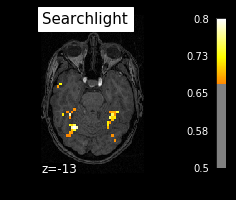

In [8]:
from niwidgets import NiftiWidget
from nilearn.plotting import plot_img, show
#convert the searchlight results into an fmri volume using the mask
searchlight_img = new_img_like(mask_img, searchlight.scores_)

# We can set the minimum threshold for accuracy, where we want to visualize the specific
# slice, etc.
subj1_anat = load_img(haxby_dataset.anat[0])
plot_img(searchlight_img, bg_img=subj1_anat,
         title="Searchlight", display_mode="z", cut_coords=[-13],
         vmin=.5, cmap='hot', threshold=.67, black_bg=True,colorbar=True)

show()

You can also save your searchlight as a nifti file and load it for visualization somewhere else (like in [AFNI](https://afni.nimh.nih.gov/) or something). This will save it to the current directory:

In [9]:
searchlight_img.to_filename("saved_searchlight.nii.gz")

In [10]:
from functools import partial # need this to properly be able to show the background anat

#passing in a parameter called bg_img to plot_img to make a partially applied function
#this allows us to see the epi on subj1_anat data
plot_img_part = partial(plot_img,bg_img=subj1_anat) 

In [11]:
plot_img_part

functools.partial(<function plot_img at 0x11f196488>, bg_img=<nibabel.nifti1.Nifti1Image object at 0x11f18de80>)

In [12]:
from niwidgets import NiftiWidget

subj_sl_widg = NiftiWidget(searchlight_img)
subj_sl_widg.nifti_plotter(plotting_func=plot_img_part, threshold=(0.5, 0.8, 0.01),
                   display_mode=['ortho','xz'])

<Figure size 432x288 with 0 Axes>

interactive(children=(FloatSlider(value=0.65, description='threshold', max=0.8, min=0.5, step=0.01), Dropdown(…